In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)

/content
/content/drive/MyDrive/LSTM project/LSTM_Project/sector_analysis(food drug)/2016-2019(before covid)


In [3]:
# sector-> Food & Drug store(2016/01/01~2019/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv", index_col=0) 
df2=pd.read_csv("WBA.csv", index_col=0)  
df3=pd.read_csv("MTRAF.csv", index_col=0)
df4=pd.read_csv("COOP.csv", index_col=0) 
df5=pd.read_csv("JSAIY.csv", index_col=0)  
df6=pd.read_csv("ADRNY.csv", index_col=0)  
df7=pd.read_csv("TSCDY.csv", index_col=0)  
df8=pd.read_csv("KR.csv", index_col=0)    
df9=pd.read_csv("AGHC.csv", index_col=0)  
df10=pd.read_csv("CRRFY.csv", index_col=0) 
df11=pd.read_csv("WNGRF.csv", index_col=0) 

print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
df3

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,27.500000,27.500000,27.500000,27.500000,25.340036,300
1,2016-01-05,27.500000,27.500000,27.500000,27.500000,25.340036,0
2,2016-01-06,27.190001,27.420000,27.190001,27.420000,25.266321,200
3,2016-01-07,27.020000,27.020000,27.020000,27.020000,24.897738,100
4,2016-01-08,27.240000,27.440001,27.219999,27.430000,25.275537,4200
...,...,...,...,...,...,...,...
1001,2019-12-24,41.259998,41.259998,41.259998,41.259998,40.273190,0
1002,2019-12-26,41.259998,41.259998,41.259998,41.259998,40.273190,0
1003,2019-12-27,41.259998,41.259998,41.259998,41.259998,40.273190,0
1004,2019-12-30,41.259998,41.259998,41.259998,41.259998,40.273190,0


# Make models (train)

In [4]:
from keras.layers import *
def make_models(all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], output_vars=[2], 
                outputs_company=1, train_size=754, time_step=60, epochs=30, units=50, batch_size=64, volume_switch=False,): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping

  # Show arguments
  inputs=['-', 'Open', 'High', 'Low', 'Close', '-', 'Volume']
  print(f"[Arguments]") 
  print(f"num_company={len(company_list)}社 {company_list}")
  print(f"input_variables={input_category}, ====> output_variables={output_category}")
  print(f"train_size={train_size}, time_step={time_step}, num_epoch={epochs}, num_units(neurons)={units}, batch_size={batch_size}")
  print("")

  print("~~Make models~~")
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  #2. normalise data
  #3. prepare both training_data and label depending on the number of inputs and outputs
  X_train=[]
  y_trains=[]
  

  training_set_all=np.hstack((data[:,:] for data in train_data))
  print(f"training_set_all={training_set_all.shape}") # (754, company_list * input_vars)
  
  ss_all=[]
  for i in range(training_set_all.shape[1]):
    ss1=StandardScaler()
    ss_all.append(ss1.fit_transform(training_set_all[:,i].reshape(-1, 1)))
  concat=np.hstack(ss_all)

  index=[]
  for i in range(len(output_vars)):
    index+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*(len(input_vars)), len(input_vars))] 
  print(index)
  
  for l in range(time_step, train_size):
    X_train.append(concat[l-time_step: l, :])
    for m in range(len(index)):
      y_trains.append(concat[l, index[m]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")

  #4. modify y_train based on the number of companies
  y_trains2=[]
  
  if len(output_vars) != 1:
    for x in range(len(all_data)*len(output_vars)):
      x_tr=np.array([y_trains[i] for i in range(x, len(y_trains), len(all_data*len(output_vars)))])
      y_trains2.append(x_tr)

  else: # len(output_i)==1
    for y in range(len(all_data)):
      y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(all_data))])
      y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2.shape}")

  model_lists = []
  
  #5. make models

  for l in range(outputs_company):
    print(f"{l+1}/{outputs_company}")

    model = Sequential()

    model.add(LSTM(units = units, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = units, return_sequences = False))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    model.fit(X_train, y_trains2[l], epochs=epochs, batch_size=batch_size)
    model_lists.append(model)
    print("")

  return model_lists, y_trains2[:outputs_company]

# Make predictions (test)


In [ ]:
# Make predictions
def make_preds(model_lists, y_trains2, all_data, company_list, input_category=['High'], input_vars=[2], output_category=['High'], 
               output_vars=[2], train_size=754, time_step=60, cm_switch=False, volume_switch=False):
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  print("~~Make predctions~~")

  #1. Prepare test_data and normalise and make predictions
  train_data=[]
  test_data=[]
  for i in range(len(all_data)):
    train_data.append(all_data[i].iloc[: train_size, input_vars].values)
    test_data.append(all_data[i].iloc[train_size:, input_vars].values)
  print(f"train_data={np.array(train_data).shape}, test_data={np.array(test_data).shape}")

  
  inputs = []
  for m in range(len(all_data)): 
    inputs.append(all_data[m].iloc[:, input_vars][len(all_data[m])-len(test_data[m])-time_step:].values)
  inputs = np.array(inputs)

  #2. normalise
  variables=[]
  ss=[]
  for i in range(len(all_data)):
    for j in range(len(input_vars)): #11*5=55
      m=inputs[i, :, j].reshape(-1, 1) 
      s=StandardScaler()
      t=s.fit_transform(m)

      variables.append(t)
      ss.append(s)
  
  inputs2=np.hstack(variables)
  s1=StandardScaler()
  inputs2=s1.fit_transform(inputs2)
  
  X_test = []
  # Use all components as imputs for testing
  for n in range(time_step, np.array(test_data).shape[1]+time_step):
    X_test.append(inputs2[n-time_step:n, :])
  X_test = np.array(X_test)

  #3. make predictiions
  preds = [] 
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))
  
  if len(output_vars)==1:
    ind=[i for i in range(input_vars.index(output_vars[0]), len(all_data)*len(input_vars), len(input_vars))]
  else:
    ind=[]
    for i in range(len(output_vars)):
      ind+=[j for j in range(input_vars.index(output_vars[i]), len(all_data)*len(input_vars), len(input_vars))]
 
  #4. scale_back normalise
  for p in range(len(y_trains2)):
    preds[p] = ss[ind[p]].inverse_transform(preds[p]) 
  preds = np.array(preds)

  #5. plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists_test=[]
  actual_lists_train=[]
  for dd in range(len(output_vars)):
    actual_lists_test+=[sc.iloc[train_size:,output_vars[dd]] for sc in all_data]
    actual_lists_train+=[sc.iloc[:train_size,output_vars[dd]] for sc in all_data]
  
  if len(output_vars) > 1:
    R2=company_list*len(output_vars) # lists of companies
  else: R2=company_list
  
  print(f"actual_lists_train={np.array(actual_lists_train).shape}, actual_lists_test={np.array(actual_lists_test).shape}, preds_list={np.array(preds).shape}")

  R=0
  r=[r for r in range(len(all_data)-1, len(R2), len(all_data))]

  plt.figure(figsize=(18, 35))
  scores_list=[]
  for p in range(len(R2)):
    if len(company_list) >=9: plt.subplot(6, 2, p+1)
    else: plt.subplot(4, 2, p+1) 
    plt.plot(all_data[0].loc[:train_size-1,'Date'], actual_lists_train[p], color='black', label='Real(Trainning)')
    plt.plot(all_data[0].loc[train_size:,'Date'], actual_lists_test[p], color='red', label='Real(Test)')
    plt.plot(all_data[0].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    plt.xticks(np.arange(0, 1006, 251))
    plt.xlabel('Date')
    if input_vars[0]=="2": plt.ylabel('High Price')
    else: plt.ylabel('Volume')
    
    from sklearn.metrics import r2_score
    r2=round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)
    scores_list.append(r2)
    plt.title(f"R2: {R2[p]}={round(r2_score(actual_lists_test[p], preds[p].flatten()), 4)}")

    R +=r2_score(actual_lists_test[p], preds[p].flatten())
    plt.legend()
  plt.show()

  # calcurate R2_average 
  if p in r:
    scores_list.append(round(R/len(all_data), 4))
    print(f"R2-{len(all_data)}companies_average={round(R/len(all_data), 4)}")
    R=0
  print(f"R2_scores_lists={scores_list}")
  print("")
  #6. Make confusion matrix
  columns = company_list # labeling 
  
  if cm_switch==True:
    for p in range(len(output_vars)):
      print(f"Preds_Heatmap='{output_category[p]}' correlation")
      prd=[preds[p] for p in range(len(company_list)*p, len(company_list)+p*len(company_list))]
      Preds= pd.DataFrame(np.concatenate(prd, axis=1))
      Preds.columns = columns
    
      plt.figure(figsize=(8, 6))
      cmap=sns.diverging_palette(220, 20, as_cmap=True)
      sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  # return preds[p].flatten() 


# 7月3日以降　


## ALL in ALL Function

In [ ]:
def multivariate_LSTM(original_all_data, num_company=11, input_category=['High'], input_vars=[2], output_category=['High'], output_vars=[2], outputs_company=11, 
               train_size=754, time_step=60, epochs=20, units=50, batch_size=64, cm_switch=False):
  
  """Define variables
  original_all_data: Financial data of all companies used
  num_company: Number of companies to be randomly selected from all companies
  input_vars: The item number of the variable to be used as input (More than one can be specified)
  output_vategory: Category name of the variable to be output (More than one can be specified)
  output_vars: The item number of the variable to be used as outputs (More than one can be specified)
  """

  all_companies_list=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 
                      'Coop Group (Switzerland)', 'J.Sainsbury(Britain)', "Royal Ahold Delhaize(Netherlands)", 
                      "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]

  # Pick up companies rondomly
  import random
  company_list=random.sample(all_companies_list, num_company) 
  all_data=[]
  for n in range(num_company):
    ind = all_companies_list.index(company_list[n])
    all_data.append(original_all_data[ind])
  
  # 　Check if the specified variable has "Volume" for training
  if 6 not in input_vars: volume_switch=False
  else: volume_switch=True

  # Make Models
  model_lists, y_trains = make_models(all_data, company_list, input_category, input_vars, output_category, 
                                      output_vars, outputs_company, train_size, time_step, epochs, units, batch_size, volume_switch)
  # Make Predictions           
  make_preds(model_lists, y_trains, all_data, company_list, input_category, input_vars, 
             output_category, output_vars, train_size, time_step, cm_switch, volume_switch)

# 関数完成チェック用(final)

In [ ]:
all_data=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
""" items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6} """

' items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6} '

1回目
[Arguments]
num_company=11社 ['Tesco(Britain)', 'Carrefour(France)', 'Royal Ahold Delhaize(Netherlands)', 'George Weston(Canada)', 'Seven & I Holdings (Japan)', 'Coop Group (Switzerland)', 'Walgreens Boots Alliance (USA)', 'Metro (Canada)', 'Kroger(USA)', 'AEON(Japan)', 'J.Sainsbury(Britain)']
input_variables=['Open', 'High', 'Low', 'Close'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(11, 754, 4), test_data=(11, 252, 4)
training_set_all=(754, 44)
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41]
X_train=(694, 60, 44), y_trains=(7634,)
y_trains2=(11, 694)
1/11
Epoch 1/50
22/22 [==============================] - 5s 20ms/step - loss: 0.4204
Epoch 2/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0961
Epoch 3/50
22/22 [==============================] - 0s 15ms/step - loss: 0.0622
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.0509
Epoch 5/50
22/22 [=

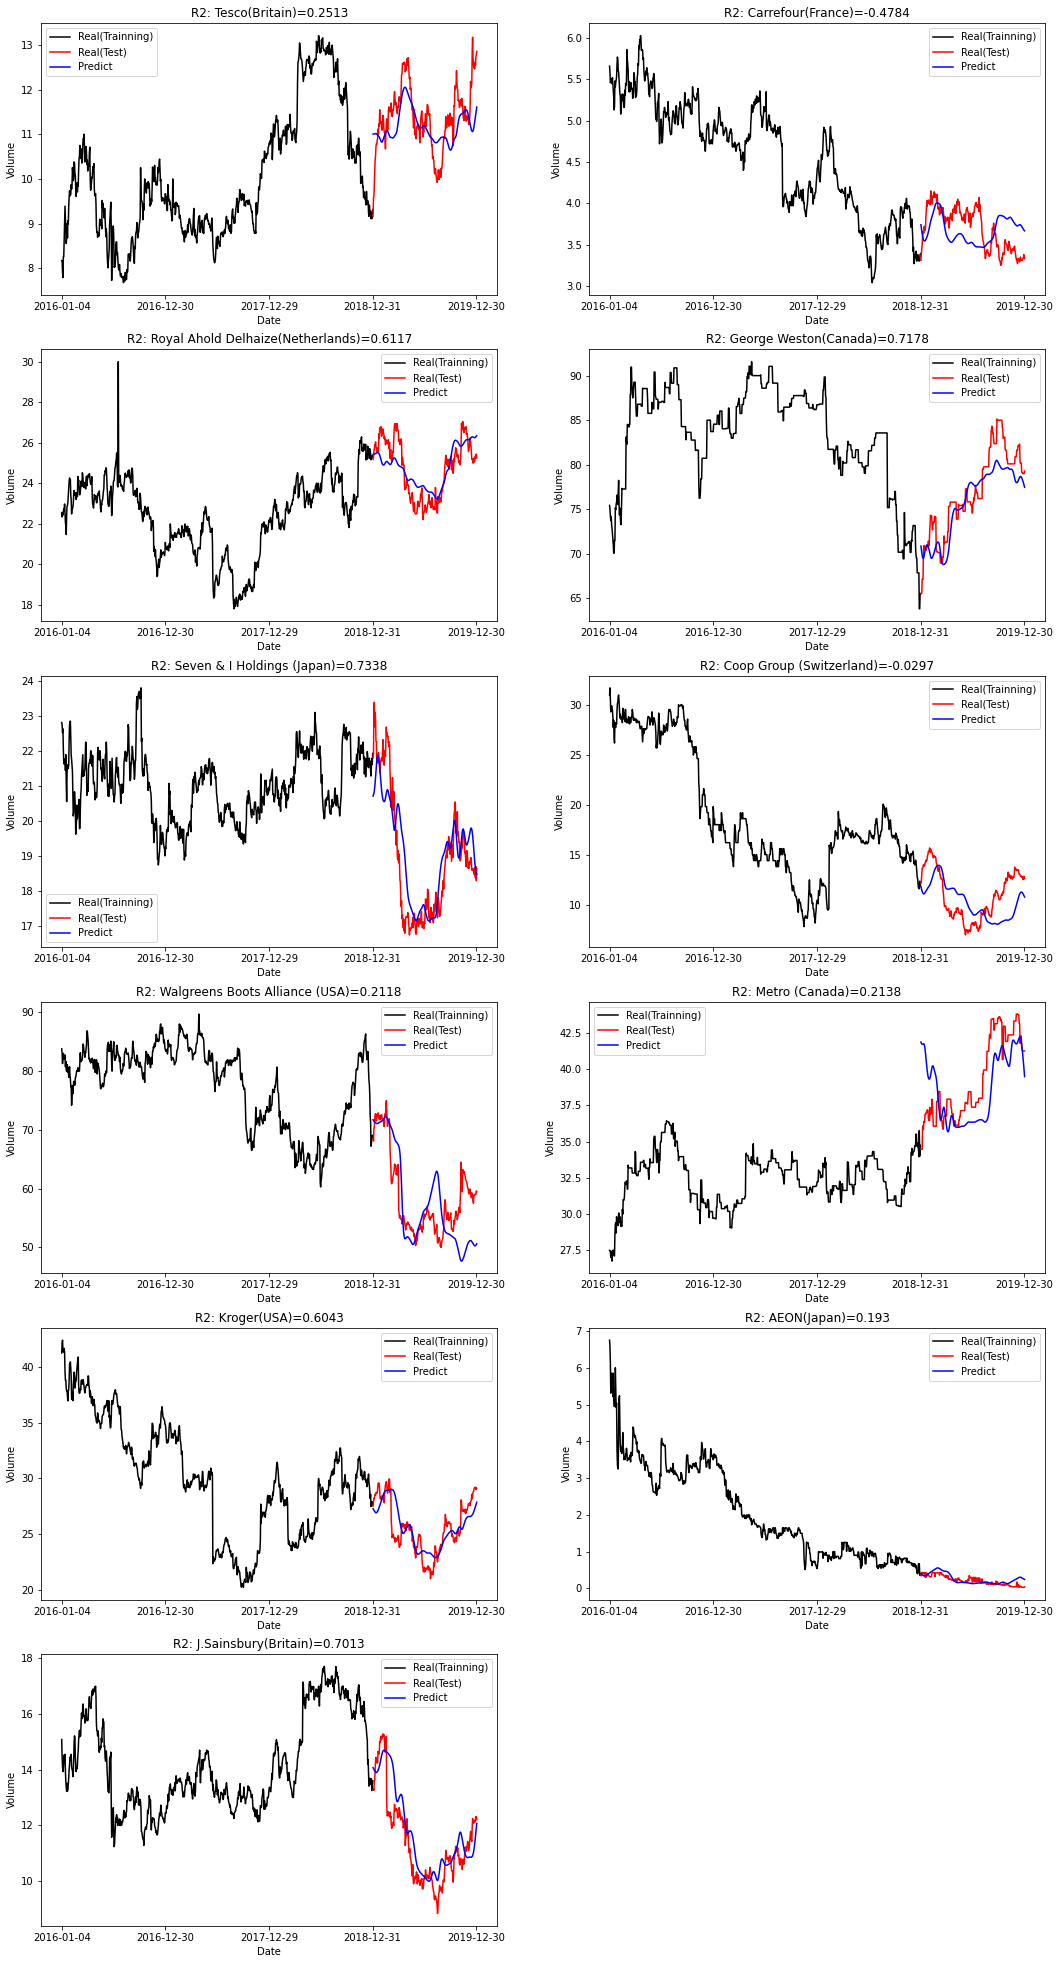

R2-11companies_average=0.3392

R2_scores_lists=[0.2513, -0.4784, 0.6117, 0.7178, 0.7338, -0.0297, 0.2118, 0.2138, 0.6043, 0.193, 0.7013, 0.3392]
2回目
[Arguments]
num_company=11社 ['Carrefour(France)', 'AEON(Japan)', 'Kroger(USA)', 'Royal Ahold Delhaize(Netherlands)', 'Metro (Canada)', 'Coop Group (Switzerland)', 'Seven & I Holdings (Japan)', 'Tesco(Britain)', 'J.Sainsbury(Britain)', 'George Weston(Canada)', 'Walgreens Boots Alliance (USA)']
input_variables=['Open', 'High', 'Low', 'Close'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(11, 754, 4), test_data=(11, 252, 4)
training_set_all=(754, 44)
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41]
X_train=(694, 60, 44), y_trains=(7634,)
y_trains2=(11, 694)
1/11
Epoch 1/50
22/22 [==============================] - 6s 21ms/step - loss: 0.3832
Epoch 2/50
22/22 [==============================] - 0s 16ms/step - loss: 0.0687
Epoch 3/50
22/22 [================

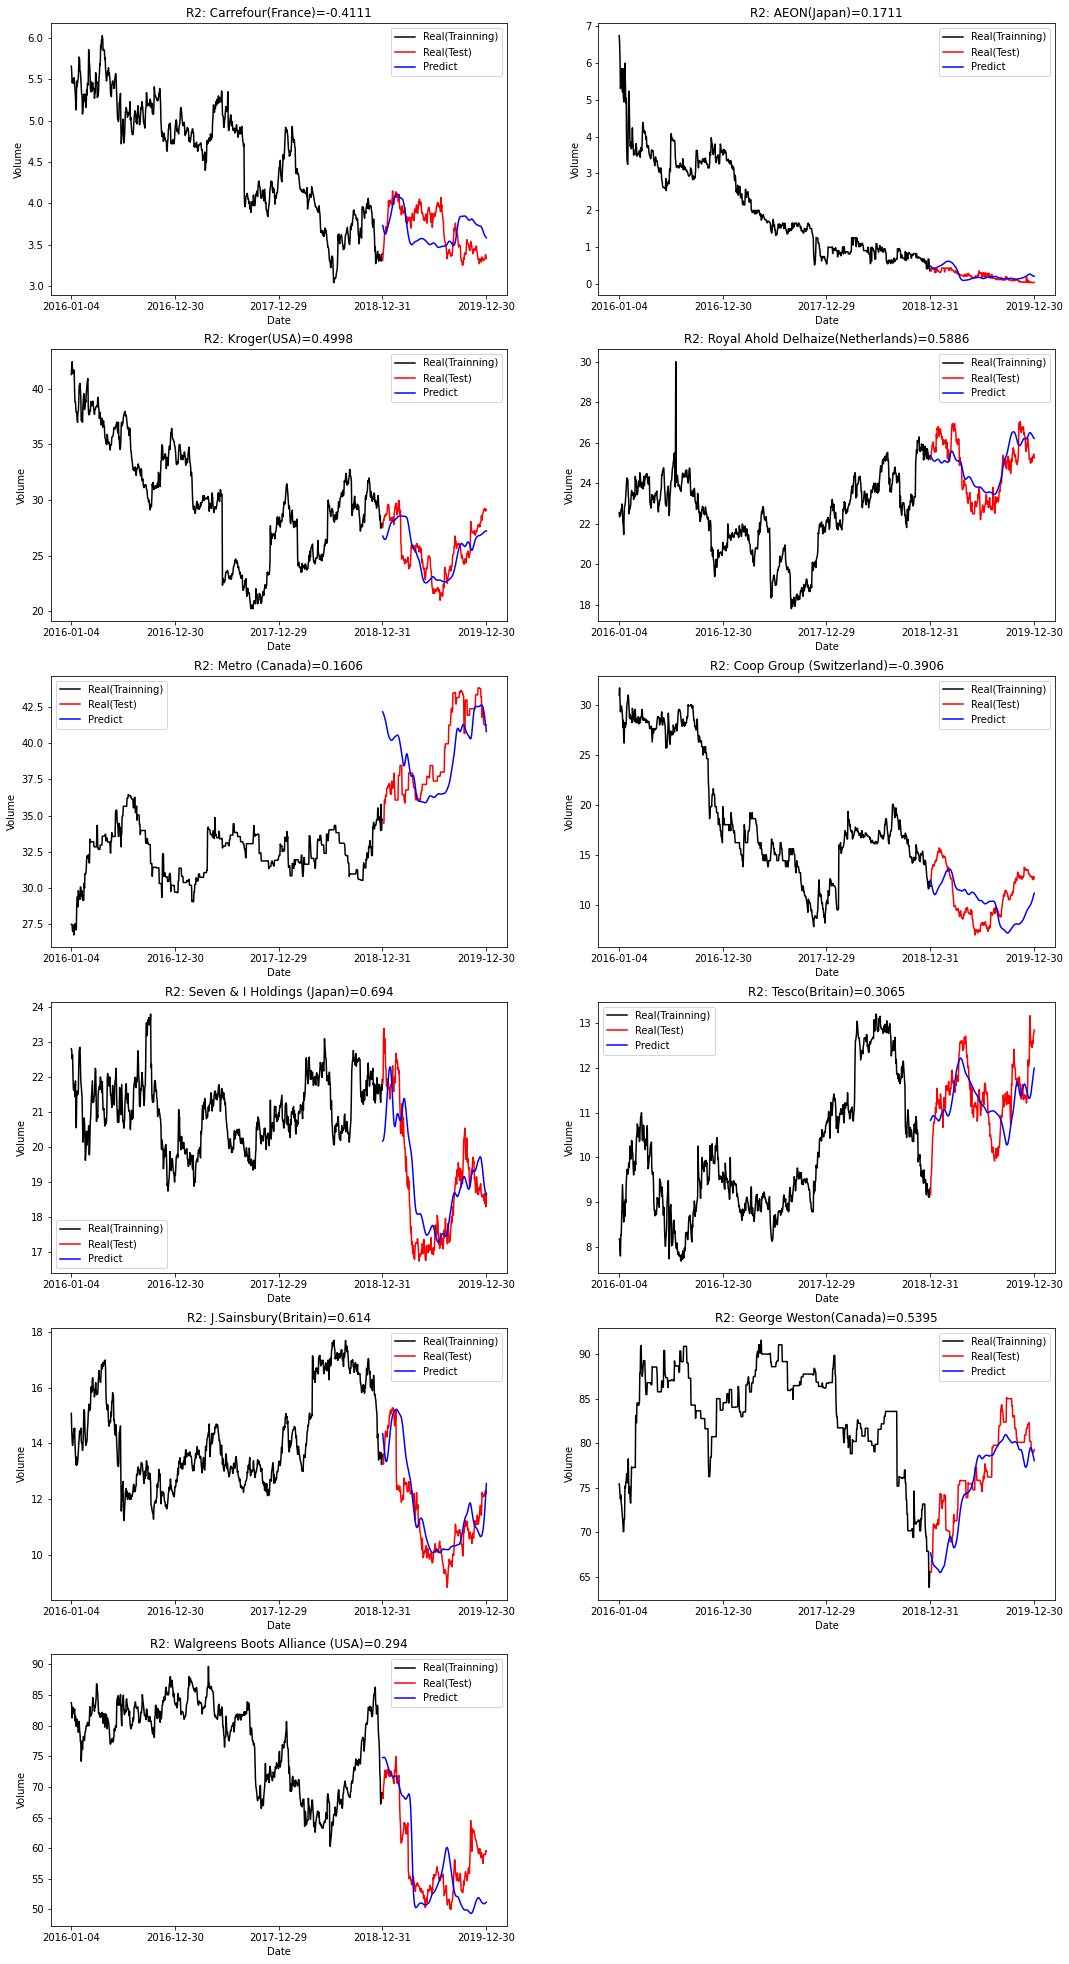

R2-11companies_average=0.2788

R2_scores_lists=[-0.4111, 0.1711, 0.4998, 0.5886, 0.1606, -0.3906, 0.694, 0.3065, 0.614, 0.5395, 0.294, 0.2788]
3回目
[Arguments]
num_company=11社 ['Coop Group (Switzerland)', 'Kroger(USA)', 'Tesco(Britain)', 'Royal Ahold Delhaize(Netherlands)', 'J.Sainsbury(Britain)', 'George Weston(Canada)', 'Carrefour(France)', 'Metro (Canada)', 'Walgreens Boots Alliance (USA)', 'Seven & I Holdings (Japan)', 'AEON(Japan)']
input_variables=['Open', 'High', 'Low', 'Close'], ====> output_variables=['High']
train_size=754, time_step=60, num_epoch=50, num_units(neurons)=100, batch_size=32

~~Make models~~
train_data=(11, 754, 4), test_data=(11, 252, 4)
training_set_all=(754, 44)
[1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41]
X_train=(694, 60, 44), y_trains=(7634,)
y_trains2=(11, 694)
1/11
Epoch 1/50
22/22 [==============================] - 6s 24ms/step - loss: 0.3687
Epoch 2/50
22/22 [==============================] - 0s 18ms/step - loss: 0.0477
Epoch 3/50
22/22 [==================

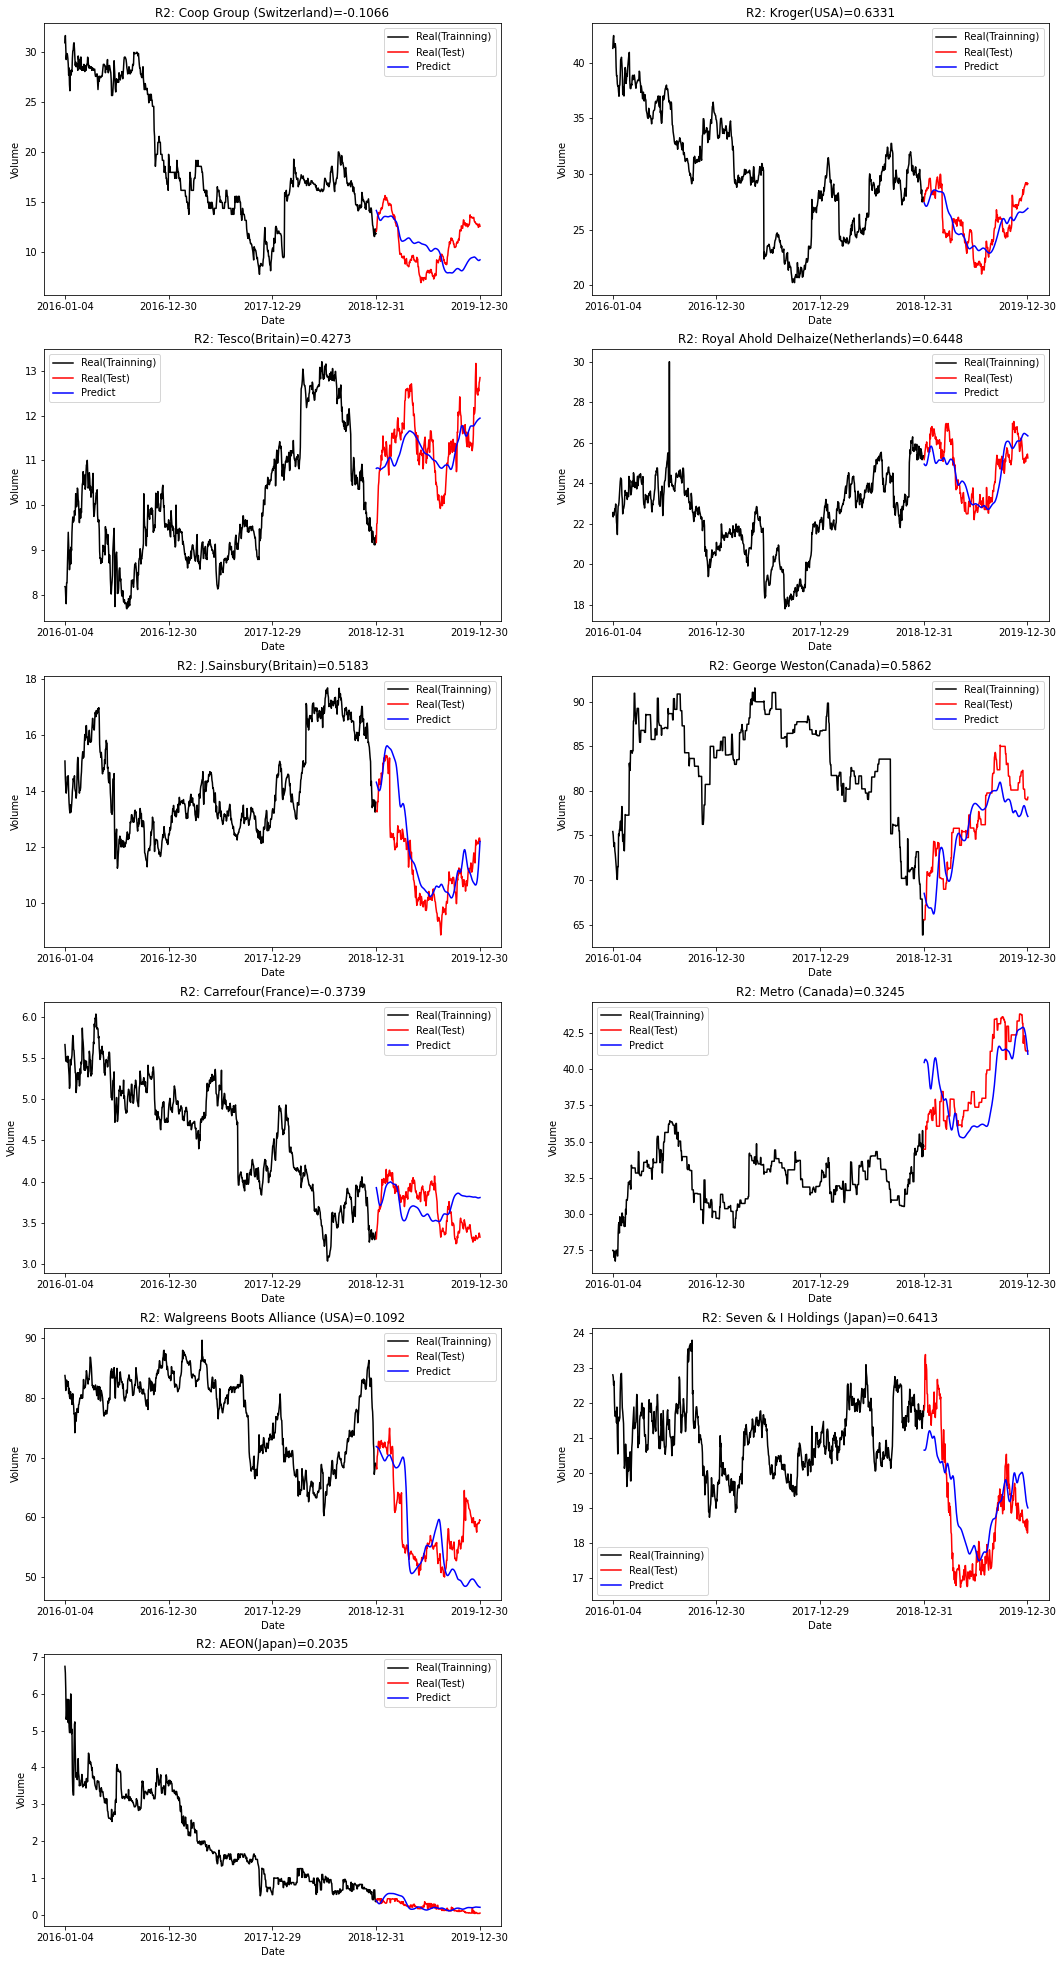

R2-11companies_average=0.328

R2_scores_lists=[-0.1066, 0.6331, 0.4273, 0.6448, 0.5183, 0.5862, -0.3739, 0.3245, 0.1092, 0.6413, 0.2035, 0.328]


In [ ]:
for i in range(3):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=11, input_category=['Open', 'High', 'Low', 'Close'], input_vars=[1, 2, 3, 4], output_category=['High'], 
                    output_vars=[2], outputs_company=11, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

In [ ]:
for i in range(10):
  print(f"{i+1}回目")
  multivariate_LSTM(all_data, num_company=5, input_category=['High'], input_vars=[2], output_category=['High'], 
                    output_vars=[2], outputs_company=5, train_size=754, time_step=60, epochs=50, units=100, batch_size=32, cm_switch=False)

Output hidden; open in https://colab.research.google.com to view.